<a href="https://colab.research.google.com/github/shihab1/Group-A-DLI-Assignment/blob/main/GNN(Shehab).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Keep Colab's core libs in a compatible state
%pip -q install "requests==2.32.3" "numpy==1.26.4" "fsspec==2025.3.0" "gcsfs==2025.3.0"

# Install PyTorch 2.6 + CUDA 12.4
%pip -q install --index-url https://download.pytorch.org/whl/cu124 \
  torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0

import torch
print("Torch:", torch.__version__, "CUDA:", torch.version.cuda)

# Install PyG deps that MATCH torch 2.6 cu124 (no resolver thrash)
%pip -q install \
  torch-scatter==2.1.2+pt26cu124 \
  torch-sparse==0.6.18+pt26cu124 \
  torch-cluster==1.6.3+pt26cu124 \
  torch-spline-conv==1.2.2+pt26cu124 \
  -f https://data.pyg.org/whl/torch-2.6.0+cu124.html

# Install the top-level package without pulling other deps
%pip -q install --no-deps torch-geometric==2.6.1

Torch: 2.6.0+cu124 CUDA: 12.4


In [2]:
%pip -q install "ipython>=8.26.0"

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython==7.34.0, but you have ipython 9.4.0 which is incompatible.


In [3]:
%load_ext autoreload
%autoreload 2
import os
import time
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn

import sys
sys.path.append('/content')

from ag_utils import Corpus, parse_ag_file, parse_node_properties
from synthetic_data import gene_dataset
from models import NN, GCN, GAT, GCN_EW
from model_utils import train, predict_prob, evaluate_performance

In [4]:

# parse attack graph file generated by MulVAL tool
attack_graph_path = '/content/AttackGraph.dot'
nodes, edges, node_properties = parse_ag_file(attack_graph_path)
node_dict = parse_node_properties(nodes, node_properties)

# save node label into corpus object
corpus = Corpus(node_dict)
num_tokens = corpus.get_num_tokens()
node_features = corpus.get_node_features()
node_types = corpus.get_node_types()
vocab_size = len(corpus.dictionary)
print('vocab_size: ', vocab_size)
print('num_tokens: ', num_tokens)
print('node_features shape: ', node_features.shape)

vocab_size:  57
num_tokens:  118
node_features shape:  torch.Size([26, 57])


In [5]:

# statistics of the encoded attack graph
num_nodes = len(nodes)
print('num_nodes: ', num_nodes)

num_node_features = node_features.shape[1]
print('num_node_features: ', num_node_features)

num_edges = len(edges)
print('num_edges: ', num_edges)

action_nodes = corpus.get_action_nodes()
action_node_idx = list(action_nodes.keys())
num_action_nodes = len(action_node_idx)
print('action_node_idx: ', action_node_idx)
print('num_action_nodes: ', num_action_nodes)

# var 'action_mask' is for representing the attack scenarios in attack graph (i.e., the privilege nodes)
action_mask = action_node_idx

num_nodes:  26
num_node_features:  57
num_edges:  26
action_node_idx:  [0, 2, 4, 7, 9, 12, 14]
num_action_nodes:  7


In [6]:
# adj matrix and edge index
adj_matrix = torch.zeros(len(nodes), len(nodes))

for edge in edges:
    source_node, target_node = edge
    source_index = nodes.index(source_node)
    target_index = nodes.index(target_node)
    adj_matrix[source_index][target_index] = 1

edge_index = adj_matrix.nonzero().t().contiguous()

assert edge_index.shape[0]==2

In [7]:
# prepare Dataset 1
num_benign = 1500
num_malic = 500
rt_meas_dim = 78
sample_method = 'synthetic'

X, Y = gene_dataset(num_benign, num_malic, num_nodes, action_nodes, rt_meas_dim)
num_samples = X.shape[0]

# rescale the data with min-max scaler
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X.view(-1, rt_meas_dim))
X = torch.from_numpy(X).float().view(num_samples, num_nodes, rt_meas_dim)

# associate node features in attack graph with real-time measurements
node_feat_ts = torch.stack([node_features for _ in range(len(X))], dim=0)
X = torch.cat((node_feat_ts, X), dim=2)

# split the data into training, validation and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42, stratify=Y_train)
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape)


torch.Size([3000, 26, 135]) torch.Size([3000, 7]) torch.Size([1000, 26, 135]) torch.Size([1000, 7]) torch.Size([1000, 26, 135]) torch.Size([1000, 7])


In [8]:
# load Dataset 1 used in the paper
data_path = '/content/datasets/'
X_train = torch.load(data_path+'X_train-{}.pth'.format(sample_method))
X_val   = torch.load(data_path+'X_val-{}.pth'.format(sample_method))
X_test  = torch.load(data_path+'X_test-{}.pth'.format(sample_method))
Y_train = torch.load(data_path+'Y_train-{}.pth'.format(sample_method))
Y_val   = torch.load(data_path+'Y_val-{}.pth'.format(sample_method))
Y_test  = torch.load(data_path+'Y_test-{}.pth'.format(sample_method))
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape)


torch.Size([3000, 26, 135]) torch.Size([3000, 7]) torch.Size([1000, 26, 135]) torch.Size([1000, 7]) torch.Size([1000, 26, 135]) torch.Size([1000, 7])


In [9]:
# hyperparameters for training
in_dim = X_train.shape[-1]  # Use the actual input dim
hidden_dim = 20
out_dim = 1
lr = 0.001
device = 'cpu'

# Model initialization (only NN)
model_NN = NN(in_dim, hidden_dim, out_dim)  # <-- use in_dim, not rt_meas_dim
model_NN.name = 'NN'
model_NN.action_mask = action_mask

num_epochs = 200  # Approximate early stopping point in paper

print(f'{model_NN.name} start training...')
time_start = time.time()
print('model: ', model_NN)

train(model_NN, lr, num_epochs, X_train, Y_train, X_val, Y_val, edge_index, in_dim, device)

time_end = time.time()
print('time cost: ', time_end - time_start)
print(f'{model_NN.name} training finished!')

print(f'{model_NN.name} accuracy on training set: {model_NN.stat["acc_train"][-1]}')
print(f'{model_NN.name} accuracy on validation set: {model_NN.stat["acc_val"][-1]}')

NN start training...
model:  NN(
  (lin1): Linear(in_features=135, out_features=20, bias=True)
  (lin2): Linear(in_features=20, out_features=20, bias=True)
  (out_layer): Linear(in_features=20, out_features=1, bias=True)
)
Epoch: 010, Training Loss: 0.5147, Traning Accuracy: 0.8631, Validation Loss: 0.5413, Validation Accuracy: 0.8614
Epoch: 020, Training Loss: 0.3809, Traning Accuracy: 0.9010, Validation Loss: 0.4188, Validation Accuracy: 0.8997
Epoch: 030, Training Loss: 0.3104, Traning Accuracy: 0.9260, Validation Loss: 0.3519, Validation Accuracy: 0.9230
Epoch: 040, Training Loss: 0.2775, Traning Accuracy: 0.9373, Validation Loss: 0.3361, Validation Accuracy: 0.9326
Epoch: 050, Training Loss: 0.2504, Traning Accuracy: 0.9461, Validation Loss: 0.3224, Validation Accuracy: 0.9396
Epoch: 060, Training Loss: 0.2291, Traning Accuracy: 0.9508, Validation Loss: 0.3172, Validation Accuracy: 0.9450
Epoch: 070, Training Loss: 0.2163, Traning Accuracy: 0.9538, Validation Loss: 0.3179, Validat

In [10]:
import torch
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

@torch.no_grad()
def evaluate_trained_nn(model, X_test, Y_test, device='cpu', threshold=0.5):
    model.eval()
    model.to(device)
    X_test = X_test.to(device)
    Y_test = Y_test.to(device)

    # Forward pass
    logits = model(X_test)  # (B, N) or (B, N, 1)
    if logits.ndim == 3 and logits.size(-1) == 1:
        logits = logits.squeeze(-1)

    # Indices of vulnerable nodes (list)
    idx = torch.as_tensor(model.action_mask, dtype=torch.long, device=device)

    # Align node dimension between logits and labels
    N_logits = logits.shape[1]
    N_labels = Y_test.shape[1]

    if N_logits == N_labels:
        # Both are full graphs -> index both
        logits_sel = logits.index_select(1, idx)
        Y_sel     = Y_test.index_select(1, idx)
    elif N_labels == idx.numel() and N_logits > N_labels:
        # Labels already masked to vulnerable nodes -> only index logits
        logits_sel = logits.index_select(1, idx)
        Y_sel     = Y_test
    elif N_logits == idx.numel() and N_labels > N_logits:
        # Logits already masked (rare) -> only index labels
        logits_sel = logits
        Y_sel     = Y_test.index_select(1, idx)
    else:
        raise ValueError(
            f"Mismatch: logits nodes={N_logits}, labels nodes={N_labels}, "
            f"indices={idx.numel()}. Can't align automatically."
        )

    # Probabilities & predictions
    probs = torch.sigmoid(logits_sel).detach().cpu().numpy().ravel()
    y_true = Y_sel.detach().cpu().numpy().astype(int).ravel()
    preds = (probs >= threshold).astype(int)

    # Metrics (micro/pooled)
    TP = int(((preds == 1) & (y_true == 1)).sum())
    FP = int(((preds == 1) & (y_true == 0)).sum())
    TN = int(((preds == 0) & (y_true == 0)).sum())
    FN = int(((preds == 0) & (y_true == 1)).sum())

    precision = TP / (TP + FP + 1e-12)
    recall    = TP / (TP + FN + 1e-12)
    f1        = 2 * precision * recall / (precision + recall + 1e-12)
    fpr       = FP / (FP + TN + 1e-12)
    fnr       = FN / (FN + TP + 1e-12)
    auc       = roc_auc_score(y_true, probs) if len(np.unique(y_true)) == 2 else float('nan')

    # Paper-style DataFrame
    return pd.DataFrame([{
        'Model': 'NN',
        'Precision': round(precision * 100, 2),
        'Recall':    round(recall * 100, 2),
        'F1-score':  round(f1 * 100, 2),
        'AUC':       round(auc * 100, 2),
        'FPR':       round(fpr * 100, 2),
        'FNR':       round(fnr * 100, 2),
        'TP': TP, 'FP': FP, 'TN': TN, 'FN': FN
    }])

# ---- Usage after training ----
df_nn = evaluate_trained_nn(model_NN, X_test, Y_test, device=device, threshold=0.5)
print(df_nn)


  Model  Precision  Recall  F1-score    AUC   FPR   FNR   TP   FP    TN  FN
0    NN      68.82   95.86     80.12  98.83  4.83  4.14  671  304  5996  29


In [12]:
from torch_geometric.data import Data
from torch_geometric.explain import GNNExplainer, Explainer

# individual case analysis
found = False
while not found:
    indi_case_id = torch.randint(0, X_test.shape[0], (1,)).item()
    y_true = Y_test[indi_case_id]
    if y_true.sum() != 0:
        found = True
        print('indi_case_id: ', indi_case_id)

indi_case_x = X_test[indi_case_id]
indi_case_x = indi_case_x.unsqueeze(0)

indi_case_id:  68


# **Improvments for Better NN**

In [13]:
# ==== CELL 1 (fixed): Helpers & alignment ====
import math, copy, numpy as np, torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

def set_seed(seed=42):
    import random
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

idx_action = torch.as_tensor(action_mask, dtype=torch.long)

def align_logits_labels(logits, Y, idx_action):
    """
    Make logits and Y refer to the same node set (either full-graph or action-only).
    Handles these cases:
      - both full -> index both by action indices
      - labels action-only, logits full -> index logits
      - logits action-only, labels full -> index labels
      - both action-only -> pass through
    """
    if logits.ndim == 3 and logits.size(-1) == 1:
        logits = logits.squeeze(-1)

    Nl = logits.shape[1]
    Ny = Y.shape[1]
    Ia = idx_action.numel()
    idx = idx_action.to(logits.device)

    if Nl == Ny:
        if Ny == Ia:
            return logits, Y                  # both already action-only
        else:
            return logits.index_select(1, idx), Y.index_select(1, idx)  # both full
    elif Ny == Ia and Nl > Ny:
        return logits.index_select(1, idx), Y  # labels action-only, logits full
    elif Nl == Ia and Ny > Nl:
        return logits, Y.index_select(1, idx)  # logits action-only, labels full
    else:
        raise ValueError(f"Cannot align: logits nodes={Nl}, labels nodes={Ny}, action={Ia}")

def compute_pos_weight(Y):
    """
    Compute pos_weight over action nodes WITHOUT blindly re-indexing if Y is already masked.
    """
    y = Y
    if y.ndim == 3: y = y.squeeze(-1)
    Ia = idx_action.numel()
    if y.shape[1] != Ia and y.shape[1] > Ia:
        y = y.index_select(1, idx_action.to(y.device))  # y was full -> make action-only
    # else: already action-only

    pos = y.sum().item()
    neg = y.numel() - pos
    if pos < 1:
        return torch.tensor(1.0, dtype=torch.float32, device=device)
    return torch.tensor(neg / pos, dtype=torch.float32, device=device)

@torch.no_grad()
def val_auc(model, Xv, Yv, batch_size=256):
    model.eval()
    probs_all, y_all = [], []
    for i in range(0, Xv.shape[0], batch_size):
        xb = Xv[i:i+batch_size].to(device)
        yb = Yv[i:i+batch_size].to(device).float()
        logits = model(xb)
        logits_sel, y_sel = align_logits_labels(logits, yb, idx_action)
        probs = torch.sigmoid(logits_sel)
        probs_all.append(probs.detach().cpu().flatten().numpy())
        y_all.append(y_sel.detach().cpu().flatten().numpy())
    y = np.concatenate(y_all)
    p = np.concatenate(probs_all)
    if len(np.unique(y)) < 2:
        return float('nan')
    return roc_auc_score(y, p)

@torch.no_grad()
def collect_probs_and_labels(model, X, Y, batch_size=256):
    model.eval()
    pa, ya = [], []
    for i in range(0, X.shape[0], batch_size):
        xb = X[i:i+batch_size].to(device)
        yb = Y[i:i+batch_size].to(device).float()
        logits = model(xb)
        logits_sel, y_sel = align_logits_labels(logits, yb, idx_action)
        pa.append(torch.sigmoid(logits_sel).detach().cpu().numpy().ravel())
        ya.append(y_sel.detach().cpu().numpy().ravel())
    return np.concatenate(pa), np.concatenate(ya)

def find_best_threshold(y_true, y_prob, metric="acc"):
    best_t, best_v = 0.5, -1
    for t in np.linspace(0.05, 0.95, 91):
        pred = (y_prob >= t).astype(int)
        if metric == "f1":
            tp = ((pred==1)&(y_true==1)).sum()
            fp = ((pred==1)&(y_true==0)).sum()
            fn = ((pred==0)&(y_true==1)).sum()
            prec = tp/(tp+fp+1e-12); rec = tp/(tp+fn+1e-12)
            val = 2*prec*rec/(prec+rec+1e-12)
        else:
            val = (pred==y_true).mean()
        if val > best_v:
            best_v, best_t = val, float(t)
    return best_t, best_v

Device: cpu


In [14]:
# ==== CELL 2: Better NN ====
class BetterNN(nn.Module):
    """
    A stronger per-node MLP:
    [Linear -> BN -> GELU -> Dropout] x 2 + residual + Linear(out)
    It processes each node's features and outputs a logit per node.
    """
    def __init__(self, in_dim, hidden=128, out_dim=1, p_drop=0.25):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden)
        self.bn1 = nn.BatchNorm1d(hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.bn2 = nn.BatchNorm1d(hidden)
        self.act = nn.GELU()
        self.drop = nn.Dropout(p_drop)
        self.out = nn.Linear(hidden, out_dim)
        self.name = "BetterNN"
        self.action_mask = action_mask  # keep for your evaluator

    def forward(self, x):
        # x: (B, N, D) -> flatten nodes into the batch, apply same MLP to each node
        B, N, D = x.shape
        x = x.view(B*N, D)
        h1 = self.drop(self.act(self.bn1(self.fc1(x))))
        h2 = self.drop(self.act(self.bn2(self.fc2(h1))))
        h = h1 + h2  # residual connection
        out = self.out(h)  # (B*N, 1)
        out = out.view(B, N, -1).squeeze(-1)  # (B, N)
        return out


In [15]:
# ==== CELL 3 (fixed): Training with early stopping & scheduler ====
def train_better_nn(
    Xtr, Ytr, Xval, Yval,
    in_dim, hidden=128, lr=2e-3, weight_decay=1e-2,
    batch_size=128, epochs=80, patience=15, seed=42
):
    set_seed(seed)
    model = BetterNN(in_dim=in_dim, hidden=hidden).to(device)
    pos_w = compute_pos_weight(Ytr)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_w)

    ds_tr = TensorDataset(Xtr, Ytr)
    ds_va = TensorDataset(Xval, Yval)
    dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True, drop_last=False)
    dl_va = DataLoader(ds_va, batch_size=batch_size, shuffle=False, drop_last=False)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    steps_per_epoch = max(1, len(dl_tr))
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=lr, epochs=epochs, steps_per_epoch=steps_per_epoch
    )

    best_auc = -1
    best_state = None
    wait = 0

    scaler = torch.cuda.amp.GradScaler(enabled=(device=='cuda'))

    for ep in range(1, epochs+1):
        model.train()
        total_loss = 0.0

        for xb, yb in dl_tr:
            xb = xb.to(device)
            yb = yb.to(device).float()

            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=(device=='cuda')):
                logits = model(xb)                                # (B, N) or (B, #action)
                logits_sel, y_sel = align_logits_labels(logits, yb, idx_action)
                loss = criterion(logits_sel, y_sel)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            total_loss += loss.item()

        va_auc = val_auc(model, Xval, Yval)
        print(f"Epoch {ep:03d} | train_loss={total_loss/len(dl_tr):.4f} | val_AUC={va_auc:.4f}")

        if va_auc > best_auc:
            best_auc = va_auc
            best_state = copy.deepcopy(model.state_dict())
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {ep}. Best val AUC = {best_auc:.4f}")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    # Threshold calibration
    p_val, y_val = collect_probs_and_labels(model, Xval, Yval)
    best_thr, best_metric = find_best_threshold(y_val, p_val, metric="acc")
    print(f"Best threshold on val = {best_thr:.2f} (val-acc={best_metric*100:.2f}%)")

    return model, best_thr, best_auc

In [16]:
# ==== CELL 4: Single strong model ====
in_dim = X_train.shape[-1]
model_bnn, thr_bnn, valAUC = train_better_nn(
    X_train, Y_train, X_val, Y_val,
    in_dim=in_dim,
    hidden=128,      # try 128 or 192
    lr=2e-3,         # a bit higher for OneCycle
    weight_decay=1e-2,
    batch_size=128,
    epochs=120,      # give it time; early stopping will cut it
    patience=20,
    seed=42
)

/tmp/ipython-input-1453774956.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=='cuda'))
/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 001 | train_loss=1.2618 | val_AUC=0.6641


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 002 | train_loss=1.1805 | val_AUC=0.7880


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 003 | train_loss=1.1073 | val_AUC=0.8519


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 004 | train_loss=1.0300 | val_AUC=0.8870


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 005 | train_loss=0.9470 | val_AUC=0.9088


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 006 | train_loss=0.8414 | val_AUC=0.9291


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 007 | train_loss=0.7380 | val_AUC=0.9496


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 008 | train_loss=0.6368 | val_AUC=0.9658


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 009 | train_loss=0.5292 | val_AUC=0.9763


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 010 | train_loss=0.4473 | val_AUC=0.9809


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 011 | train_loss=0.3732 | val_AUC=0.9842


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 012 | train_loss=0.3322 | val_AUC=0.9854


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 013 | train_loss=0.3102 | val_AUC=0.9866


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 014 | train_loss=0.2742 | val_AUC=0.9896


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 015 | train_loss=0.2600 | val_AUC=0.9894


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 016 | train_loss=0.2385 | val_AUC=0.9901


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 017 | train_loss=0.2221 | val_AUC=0.9892


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 018 | train_loss=0.2009 | val_AUC=0.9896


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 019 | train_loss=0.1988 | val_AUC=0.9900


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 020 | train_loss=0.1965 | val_AUC=0.9873


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 021 | train_loss=0.2068 | val_AUC=0.9908


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 022 | train_loss=0.2004 | val_AUC=0.9890


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 023 | train_loss=0.1798 | val_AUC=0.9892


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 024 | train_loss=0.1736 | val_AUC=0.9891


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 025 | train_loss=0.1642 | val_AUC=0.9902


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 026 | train_loss=0.1701 | val_AUC=0.9911


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 027 | train_loss=0.1659 | val_AUC=0.9891


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 028 | train_loss=0.1642 | val_AUC=0.9885


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 029 | train_loss=0.1674 | val_AUC=0.9911


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 030 | train_loss=0.1497 | val_AUC=0.9912


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 031 | train_loss=0.1541 | val_AUC=0.9882


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 032 | train_loss=0.1461 | val_AUC=0.9899


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 033 | train_loss=0.1393 | val_AUC=0.9873


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 034 | train_loss=0.1546 | val_AUC=0.9910


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 035 | train_loss=0.1380 | val_AUC=0.9903


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 036 | train_loss=0.1359 | val_AUC=0.9899


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 037 | train_loss=0.1235 | val_AUC=0.9826


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 038 | train_loss=0.1288 | val_AUC=0.9890


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 039 | train_loss=0.1193 | val_AUC=0.9919


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 040 | train_loss=0.1377 | val_AUC=0.9910


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 041 | train_loss=0.1202 | val_AUC=0.9915


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 042 | train_loss=0.1312 | val_AUC=0.9887


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 043 | train_loss=0.1204 | val_AUC=0.9903


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 044 | train_loss=0.1123 | val_AUC=0.9891


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 045 | train_loss=0.1205 | val_AUC=0.9903


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 046 | train_loss=0.0974 | val_AUC=0.9922


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 047 | train_loss=0.0880 | val_AUC=0.9921


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 048 | train_loss=0.0915 | val_AUC=0.9889


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 049 | train_loss=0.1008 | val_AUC=0.9880


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 050 | train_loss=0.1001 | val_AUC=0.9916


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 051 | train_loss=0.0987 | val_AUC=0.9917


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 052 | train_loss=0.1107 | val_AUC=0.9889


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 053 | train_loss=0.1259 | val_AUC=0.9876


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 054 | train_loss=0.1245 | val_AUC=0.9910


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 055 | train_loss=0.0891 | val_AUC=0.9917


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 056 | train_loss=0.0856 | val_AUC=0.9921


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 057 | train_loss=0.0857 | val_AUC=0.9913


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 058 | train_loss=0.0810 | val_AUC=0.9915


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 059 | train_loss=0.0743 | val_AUC=0.9914


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 060 | train_loss=0.0690 | val_AUC=0.9901


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 061 | train_loss=0.0650 | val_AUC=0.9927


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 062 | train_loss=0.0709 | val_AUC=0.9927


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 063 | train_loss=0.0660 | val_AUC=0.9931


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 064 | train_loss=0.0625 | val_AUC=0.9927


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 065 | train_loss=0.0592 | val_AUC=0.9928


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 066 | train_loss=0.0542 | val_AUC=0.9927


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 067 | train_loss=0.0551 | val_AUC=0.9915


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 068 | train_loss=0.0589 | val_AUC=0.9911


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 069 | train_loss=0.0578 | val_AUC=0.9927


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 070 | train_loss=0.0544 | val_AUC=0.9923


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 071 | train_loss=0.0577 | val_AUC=0.9923


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 072 | train_loss=0.0538 | val_AUC=0.9907


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 073 | train_loss=0.0564 | val_AUC=0.9908


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 074 | train_loss=0.0528 | val_AUC=0.9907


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 075 | train_loss=0.0432 | val_AUC=0.9921


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 076 | train_loss=0.0420 | val_AUC=0.9928


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 077 | train_loss=0.0415 | val_AUC=0.9919


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 078 | train_loss=0.0411 | val_AUC=0.9919


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 079 | train_loss=0.0427 | val_AUC=0.9924


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 080 | train_loss=0.0434 | val_AUC=0.9924


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 081 | train_loss=0.0413 | val_AUC=0.9917


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 082 | train_loss=0.0376 | val_AUC=0.9921


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 083 | train_loss=0.0324 | val_AUC=0.9925
Early stopping at epoch 83. Best val AUC = 0.9931
Best threshold on val = 0.83 (val-acc=97.64%)


=== TEST RESULTS (threshold calibrated on VAL) ===


,Model,Calibrated Thr,Val Acc (%),Accuracy (%),Precision (%),Recall (%),F1-score (%),AUC (%),TP,FP,TN,FN
0,model_bnn,0.83,97.64,97.54,86.97,88.71,87.84,99.02,621,93,6207,79
1,model_NN,0.91,97.13,97.19,84.79,87.57,86.16,98.83,613,110,6190,87


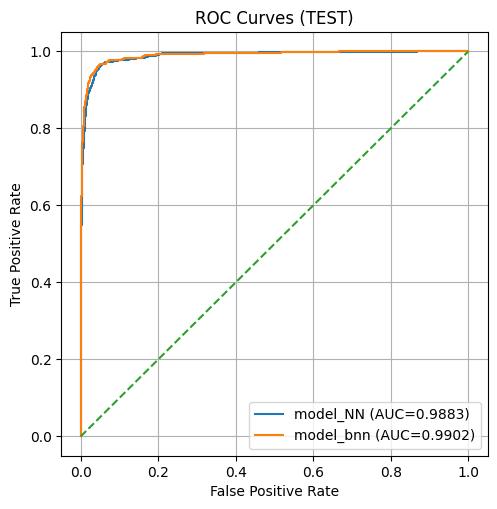

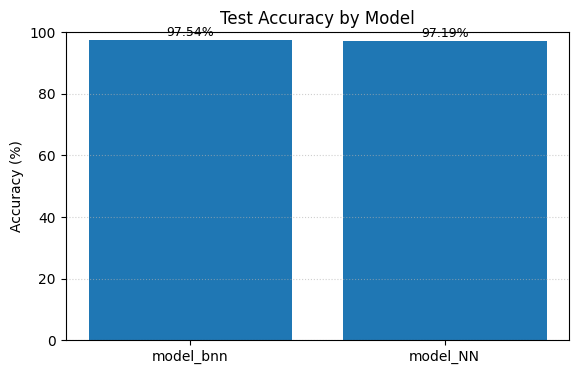

In [17]:
# ==== CELL X: Post-Cell-4 summary (tables + ROC + accuracy bar) ====
import numpy as np, pandas as pd, torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ---------- helpers (self-contained) ----------
def _ensure_tensor_mask(action_mask, device):
    if isinstance(action_mask, torch.Tensor):
        return action_mask.to(device)
    return torch.as_tensor(action_mask, dtype=torch.long, device=device)

def _align_logits_labels(logits, Y, action_mask_t):
    # logits: (B, N) or (B, N, 1); Y: (B, N) or (B, #action)
    if logits.ndim == 3 and logits.size(-1) == 1:
        logits = logits.squeeze(-1)
    Nl = logits.shape[1]; Ny = Y.shape[1]; Ia = action_mask_t.numel()
    if Nl == Ny:
        if Ny == Ia:
            return logits, Y.float()
        else:
            return logits.index_select(1, action_mask_t), Y.index_select(1, action_mask_t).float()
    elif Ny == Ia and Nl > Ny:
        return logits.index_select(1, action_mask_t), Y.float()
    elif Nl == Ia and Ny > Nl:
        return logits, Y.index_select(1, action_mask_t).float()
    else:
        raise ValueError(f"Cannot align: logits nodes={Nl}, labels nodes={Ny}, action={Ia}")

@torch.no_grad()
def _collect_probs_labels(model, X, Y, action_mask, device='cpu', batch=256):
    model.eval(); model.to(device)
    idx = _ensure_tensor_mask(action_mask, device)
    P, T = [], []
    for i in range(0, X.shape[0], batch):
        xb = X[i:i+batch].to(device)
        yb = Y[i:i+batch].to(device)
        lo = model(xb)
        lo, ys = _align_logits_labels(lo, yb, idx)
        P.append(torch.sigmoid(lo).detach().cpu().numpy().ravel())
        T.append(ys.detach().cpu().numpy().astype(int).ravel())
    return np.concatenate(P), np.concatenate(T)

def _best_acc_threshold(y, p):
    best_t, best_a = 0.5, -1.0
    # coarse -> fine sweep
    for t in np.linspace(0.02, 0.98, 97):
        a = ((p >= t).astype(int) == y).mean()
        if a > best_a: best_a, best_t = a, float(t)
    lo, hi = max(0.0, best_t-0.05), min(0.98, best_t+0.05)
    for t in np.linspace(lo, hi, 101):
        a = ((p >= t).astype(int) == y).mean()
        if a > best_a: best_a, best_t = a, float(t)
    return best_t, best_a

def _metrics(y, p, thr):
    pred = (p >= thr).astype(int)
    TP = int(((pred==1)&(y==1)).sum()); FP = int(((pred==1)&(y==0)).sum())
    TN = int(((pred==0)&(y==0)).sum()); FN = int(((pred==0)&(y==1)).sum())
    acc = (TP+TN)/max(1,(TP+TN+FP+FN))
    prec = TP/(TP+FP+1e-12); rec = TP/(TP+FN+1e-12)
    f1 = 2*prec*rec/(prec+rec+1e-12)
    try:
        rocAUC = auc(*roc_curve(y, p)[:2])
    except Exception:
        rocAUC = float('nan')
    return {
        "Accuracy (%)": round(acc*100, 2),
        "Precision (%)": round(prec*100, 2),
        "Recall (%)": round(rec*100, 2),
        "F1-score (%)": round(f1*100, 2),
        "AUC (%)": round(rocAUC*100, 2) if rocAUC==rocAUC else "nan",
        "TP": TP, "FP": FP, "TN": TN, "FN": FN
    }

# ---------- gather available models ----------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
candidates = {}  # name -> (model, preferred_threshold_if_any)

# Try to include common variables if they exist
for name in ["model_NN", "model_bnn", "model_af", "model_better", "model_acc99", "model"]:
    if name in globals():
        m = globals()[name]
        try:
            _ = m(X_val[:1].to(device))  # sanity forward
            candidates[name] = (m, None)  # we'll calibrate thresholds ourselves
        except Exception:
            pass

# Optional: use saved thresholds if you have them (e.g., thr_bnn from Cell 4)
if "thr_bnn" in globals() and "model_bnn" in candidates:
    m, _ = candidates["model_bnn"]
    candidates["model_bnn"] = (m, float(thr_bnn))

if not candidates:
    raise RuntimeError("No trained models found (expected model_NN, model_bnn, etc.). Train first.")

# ---------- compute VAL calibration + TEST metrics ----------
rows = []
roc_data = []  # for plotting ROC

for name, (model, preset_thr) in candidates.items():
    # Calibrate on VALIDATION for a fair comparison
    p_val, y_val = _collect_probs_labels(model, X_val, Y_val, action_mask, device=device)
    if preset_thr is None:
        thr, val_acc = _best_acc_threshold(y_val, p_val)
    else:
        thr, val_acc = preset_thr, ((p_val >= preset_thr).astype(int) == y_val).mean()

    # TEST metrics at that threshold
    p_test, y_test = _collect_probs_labels(model, X_test, Y_test, action_mask, device=device)
    met = _metrics(y_test, p_test, thr)
    rows.append({
        "Model": name,
        "Calibrated Thr": round(float(thr), 2),
        "Val Acc (%)": round(val_acc*100, 2),
        **met
    })

    # ROC data (test)
    try:
        fpr, tpr, _ = roc_curve(y_test, p_test)
        rocAUC = auc(fpr, tpr)
        roc_data.append((name, fpr, tpr, rocAUC))
    except Exception:
        pass

# ---------- display table (sorted by Test Accuracy) ----------
df = pd.DataFrame(rows).sort_values(by="Accuracy (%)", ascending=False).reset_index(drop=True)
print("=== TEST RESULTS (threshold calibrated on VAL) ===")
display(df)

# ---------- plots ----------
# 1) ROC curves
plt.figure(figsize=(5.5, 5.5))
for name, fpr, tpr, rocAUC in roc_data:
    plt.plot(fpr, tpr, label=f"{name} (AUC={rocAUC:.4f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves (TEST)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 2) Accuracy bar chart
plt.figure(figsize=(6.5, 4.0))
plt.bar(df["Model"], df["Accuracy (%)"])
plt.ylabel("Accuracy (%)"); plt.title("Test Accuracy by Model")
plt.ylim(0, 100)
for i, v in enumerate(df["Accuracy (%)"]):
    plt.text(i, v + 0.3, f"{v:.2f}%", ha="center", va="bottom", fontsize=9)
plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.show()